# Correlation Analysis: News Sentiment vs. Stock Metrics

This notebook analyzes the correlation between news sentiment (from `raw_analyst_ratings.csv`) and stock metrics (from yfinance data) for stocks like AAPL, AMZN, GOOG, META, MSFT, NVDA, and TSLA. It includes:
- Sentiment analysis on headlines using VADER.
- Financial metrics (returns, volatility, RSI).
- Pearson and Spearman correlations, including lagged effects.
- Visualizations: correlation heatmaps, scatter plots, time series, and box plots.
- Enhancements: trading hours filter, publisher-weighted sentiment, topic-specific correlations.
- Fix for module imports by adding `src` to `sys.path`.
- Optional sampling for large datasets.

## 1. Setup and Imports

Configure module paths and import libraries.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import spearmanr
import os
import sys

# Add src directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust if notebook is not in notebooks/
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
print(f"sys.path includes: {src_path}")

# Verify src folder exists
if not os.path.exists(src_path):
    raise FileNotFoundError(f"src folder not found at {src_path}")

# Custom modules
try:
    from quant_data import load_yfinance_data
    from quant_indicators import add_sma, add_ema, add_rsi, add_macd
    from eda_text import extract_keywords, simple_topic_modeling
    from eda_publisher import top_publishers, publisher_domains
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(f"Failed to import custom modules. Ensure files are in {src_path}. Error: {e}")


# Use seaborn's style settings
sns.set()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

sys.path includes: c:\Users\hp\Desktop\Stock-market-movement-prediction-using-news-sentiment-nlp-\src


## 2. Load and Prepare Data

Load analyst ratings and stock data, standardize formats, and merge datasets.

In [6]:
# Define data paths
data_path = os.path.join(project_root, 'data')
ratings_file = os.path.join(data_path, 'raw_analyst_ratings.csv')
yfinance_dir = os.path.join(data_path, 'yfinance_data')

# Verify data files exist
if not os.path.exists(ratings_file):
    raise FileNotFoundError(f"Ratings file not found at {ratings_file}")
if not os.path.exists(yfinance_dir):
    raise FileNotFoundError(f"Yfinance data directory not found at {yfinance_dir}")

# Load analyst ratings
ratings_df = pd.read_csv(ratings_file)
ratings_df['date'] = pd.to_datetime(ratings_df['date'], errors='coerce')

# Optional: Sample 10% for large datasets (uncomment if slow)
# ratings_df = ratings_df.sample(frac=0.1, random_state=42)

# Load stock data
stock_df = load_yfinance_data(yfinance_dir)

# Add technical indicators
stock_df = add_sma(stock_df, window=20)
stock_df = add_ema(stock_df, window=20)
stock_df = add_rsi(stock_df, window=14)
stock_df = add_macd(stock_df)

# Calculate daily returns and volatility
stock_df['Return'] = stock_df.groupby('Ticker')['Close'].pct_change()
stock_df['Volatility_20'] = stock_df.groupby('Ticker')['Return'].rolling(window=20).std().reset_index(level=0, drop=True)

# Check ticker overlap
common_tickers = set(ratings_df['stock']).intersection(stock_df['Ticker'])
print(f"Common Tickers: {common_tickers}")
if not common_tickers:
    raise ValueError("No common tickers between datasets. Check 'stock' in ratings and 'Ticker' in yfinance data.")

# Filter datasets to common tickers
ratings_df = ratings_df[ratings_df['stock'].isin(common_tickers)]
stock_df = stock_df[stock_df['Ticker'].isin(common_tickers)]

# Standardize date for merging
ratings_df['Date'] = ratings_df['date'].dt.date
stock_df['Date'] = stock_df['Date'].dt.date

# Filter news to trading hours (9 AM–4 PM)
ratings_df['hour'] = ratings_df['date'].dt.hour
ratings_df = ratings_df[ratings_df['hour'].between(9, 16)]

# Merge datasets
merged_df = pd.merge(ratings_df, stock_df, left_on=['stock', 'Date'], right_on=['Ticker', 'Date'], how='inner')
print(f"Merged DataFrame Shape: {merged_df.shape}")

Common Tickers: {'AAPL', 'GOOG', 'NVDA', 'TSLA', 'AMZN'}
Merged DataFrame Shape: (32, 25)


## 3. Sentiment Analysis

Perform sentiment analysis on headlines and aggregate by day and stock.

In [7]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment
ratings_df['Sentiment'] = ratings_df['headline'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Weight sentiment by publisher credibility
top_pubs = top_publishers(ratings_df, top_n=10).index
ratings_df['Weight'] = ratings_df['publisher'].apply(lambda x: 2 if x in top_pubs else 1)
ratings_df['Weighted_Sentiment'] = ratings_df['Sentiment'] * ratings_df['Weight']

# Aggregate daily sentiment
daily_sentiment = ratings_df.groupby(['stock', 'Date']).agg({
    'Sentiment': 'mean',
    'Weighted_Sentiment': 'mean'
}).reset_index()
daily_sentiment.rename(columns={'stock': 'Ticker'}, inplace=True)

# Merge with stock data
analysis_df = pd.merge(daily_sentiment, stock_df[['Ticker', 'Date', 'Return', 'Volatility_20', 'RSI_14', 'MACD']], on=['Ticker', 'Date'], how='inner')
print(f"Analysis DataFrame Shape: {analysis_df.shape}")

Analysis DataFrame Shape: (14, 8)


## 4. Keyword Filtering

Filter headlines with financial keywords.

In [9]:
# Extract top keywords
keywords = extract_keywords(ratings_df, top_n=50)
financial_keywords = ['earnings', 'buy', 'sell', 'upgrade', 'downgrade', 'rating', 'price', 'target', 'analyst', 'stock']
print(f"Top Keywords:") # Corrected line 4
print(keywords)       # Add this line

# Filter headlines
ratings_filtered = ratings_df[ratings_df['headline'].str.contains('|'.join(financial_keywords), case=False, na=False)]

# Recalculate sentiment
daily_sentiment_filtered = ratings_filtered.groupby(['stock', 'Date'])['Sentiment'].mean().reset_index()
daily_sentiment_filtered.rename(columns={'stock': 'Ticker'}, inplace=True)

# Merge filtered sentiment
analysis_df_filtered = pd.merge(daily_sentiment_filtered, stock_df[['Ticker', 'Date', 'Return', 'Volatility_20', 'RSI_14']], on=['Ticker', 'Date'], how='inner')
print(f"Filtered Analysis DataFrame Shape: {analysis_df_filtered.shape}")

Top Keywords:
[('market', 11), ('shares', 7), ('trading', 6), ('higher', 5), ('despite', 5), ('amazon', 5), ('5', 5), ('weakness', 4), ('google', 4), ('stats', 4), ('minutes', 4), ('tesla', 4), ('tech', 3), ('stocks', 3), ('apple', 3), ('report', 3), ('currently', 3), ('company', 3), ('us', 3), ('recently', 3), ('technology', 3), ('companies', 3), ('sector', 3), ('appears', 3), ('1000', 3), ('faangs', 2), ('strong', 2), ('start', 2), ('day', 2), ('awaits', 2), ('fed', 2), ('could', 2), ('seeing', 2), ('companyspecific', 2), ('news', 2), ('session', 2), ('high', 2), ('business', 2), ('cannabis', 2), ('cannaphyll', 2), ('marketing', 2), ('massconsumer', 2), ('platforms', 2), ('covid19', 2), ('cnbc', 2), ('bofa', 2), ('target', 2), ('upside', 2), ('alerts', 2), ('maps', 2)]
Filtered Analysis DataFrame Shape: (8, 6)


## 5. Correlation Analysis

Compute Pearson and Spearman correlations, including lagged effects.

In [10]:
# Correlation function
def compute_correlations(df, sentiment_col='Sentiment'):
    results = {}
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].dropna()
        if len(ticker_data) < 10:
            continue
        pearson_corr = ticker_data[[sentiment_col, 'Return', 'Volatility_20', 'RSI_14']].corr(method='pearson')
        spearman_corr = ticker_data[[sentiment_col, 'Return', 'Volatility_20', 'RSI_14']].corr(method='spearman')
        ticker_data['Return_t+1'] = ticker_data['Return'].shift(-1)
        lagged_pearson = ticker_data[[sentiment_col, 'Return_t+1']].corr(method='pearson').iloc[0, 1]
        lagged_spearman, _ = spearmanr(ticker_data[sentiment_col], ticker_data['Return_t+1'], nan_policy='omit')
        results[ticker] = {
            'Pearson': pearson_corr.loc[sentiment_col, ['Return', 'Volatility_20', 'RSI_14']].to_dict(),
            'Spearman': spearman_corr.loc[sentiment_col, ['Return', 'Volatility_20', 'RSI_14']].to_dict(),
            'Lagged_Pearson_Return': lagged_pearson,
            'Lagged_Spearman_Return': lagged_spearman,
            'Pearson_Matrix': pearson_corr,
            'Spearman_Matrix': spearman_corr
        }
    return results

# Compute correlations
corr_results = compute_correlations(analysis_df, 'Weighted_Sentiment')
corr_results_filtered = compute_correlations(analysis_df_filtered, 'Sentiment')

# Display results
for ticker, result in corr_results.items():
    print(f"\n{ticker} Correlations (Weighted Sentiment):")
    print("Pearson:", result['Pearson'])
    print("Spearman:", result['Spearman'])
    print(f"Lagged Pearson (Return t+1): {result['Lagged_Pearson_Return']:.4f}")
    print(f"Lagged Spearman (Return t+1): {result['Lagged_Spearman_Return']:.4f}")

for ticker, result in corr_results_filtered.items():
    print(f"\n{ticker} Correlations (Filtered Sentiment):")
    print("Pearson:", result['Pearson'])
    print("Spearman:", result['Spearman'])
    print(f"Lagged Pearson (Return t+1): {result['Lagged_Pearson_Return']:.4f}")
    print(f"Lagged Spearman (Return t+1): {result['Lagged_Spearman_Return']:.4f}")

## 6. Visualizations

Generate correlation heatmaps, scatter plots, time series, and box plots.

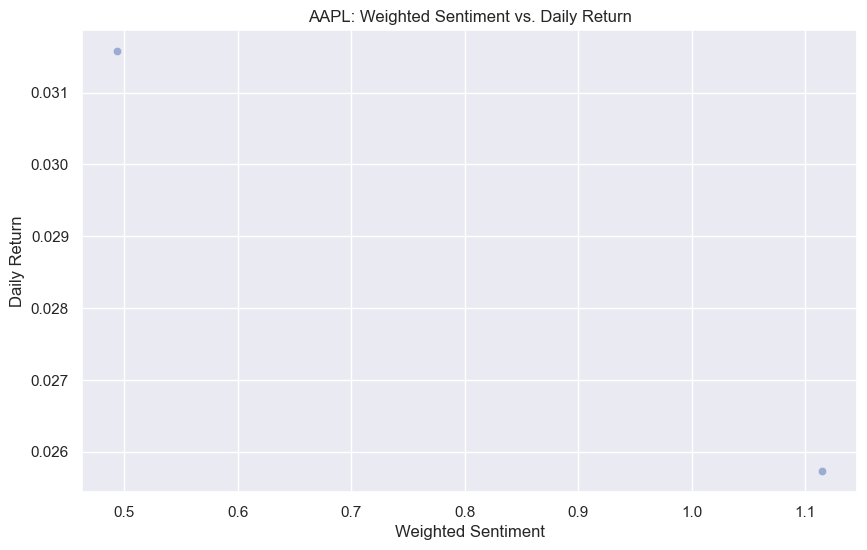

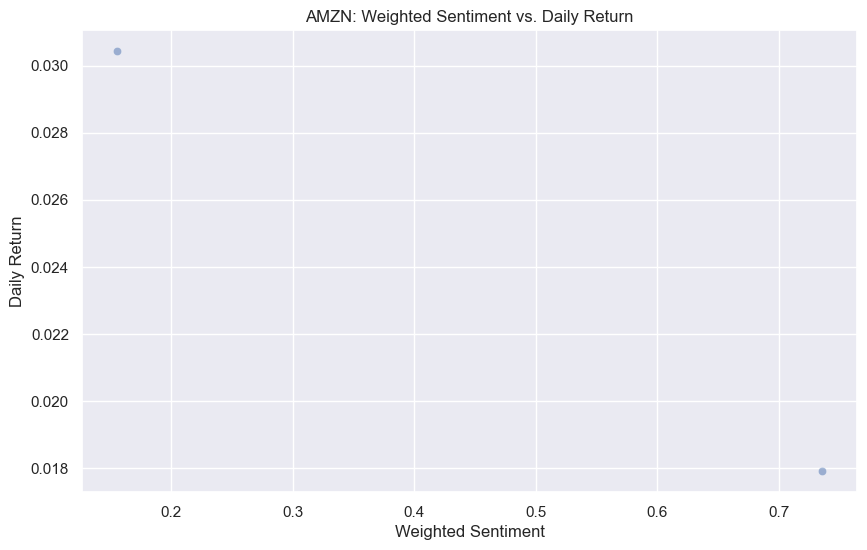

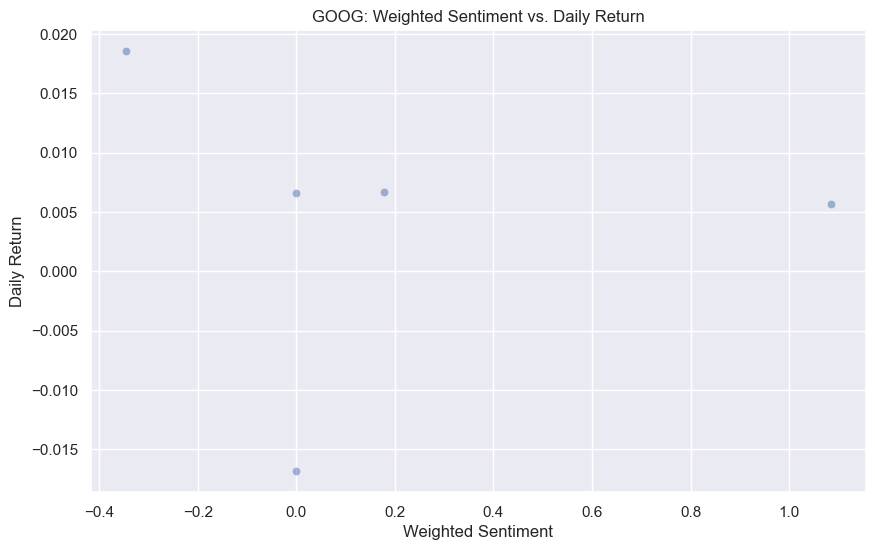

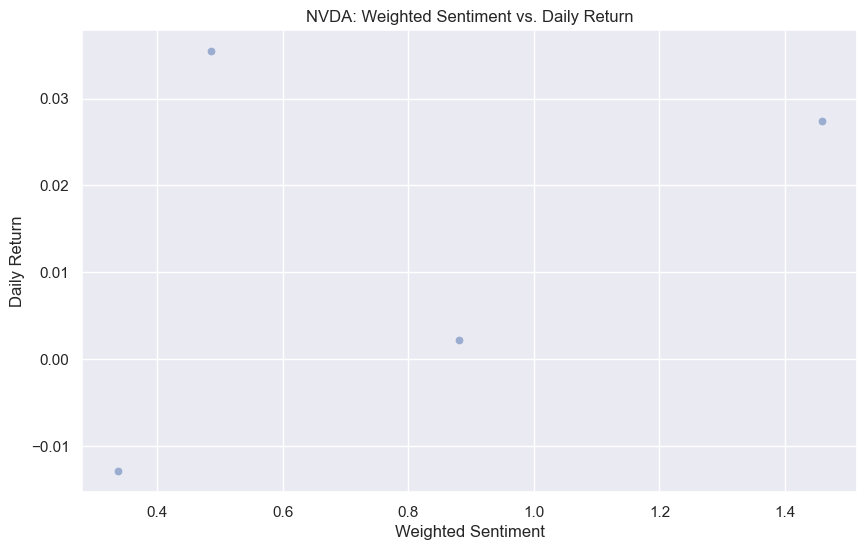

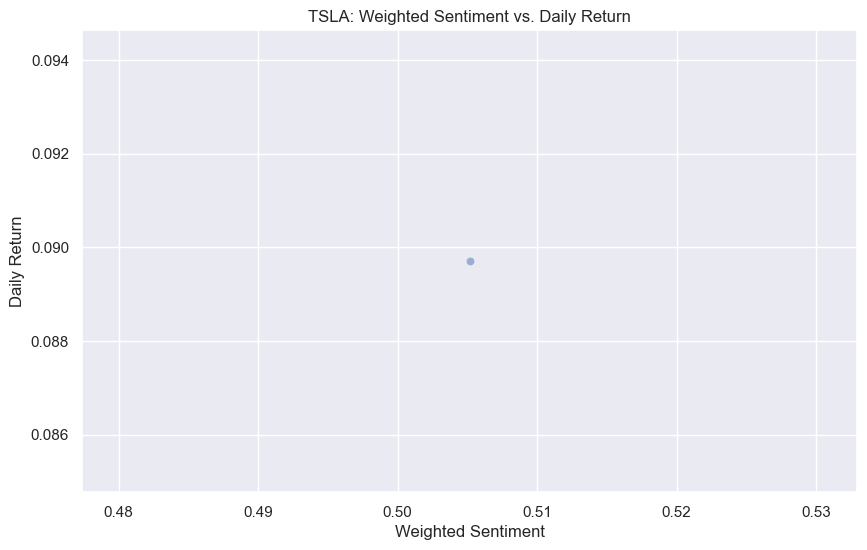

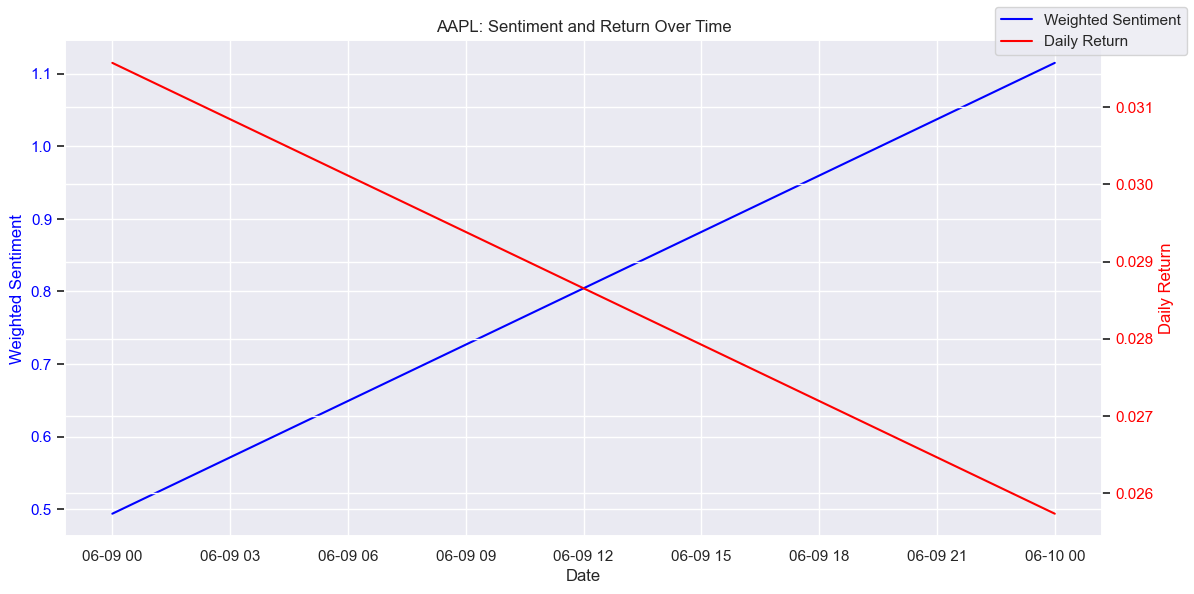

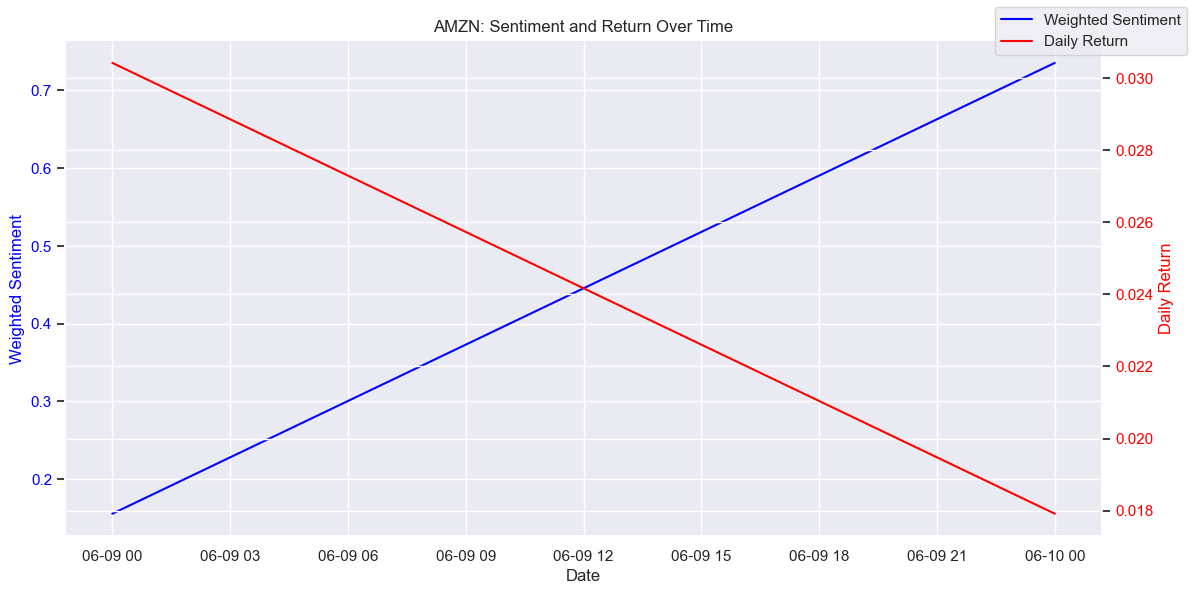

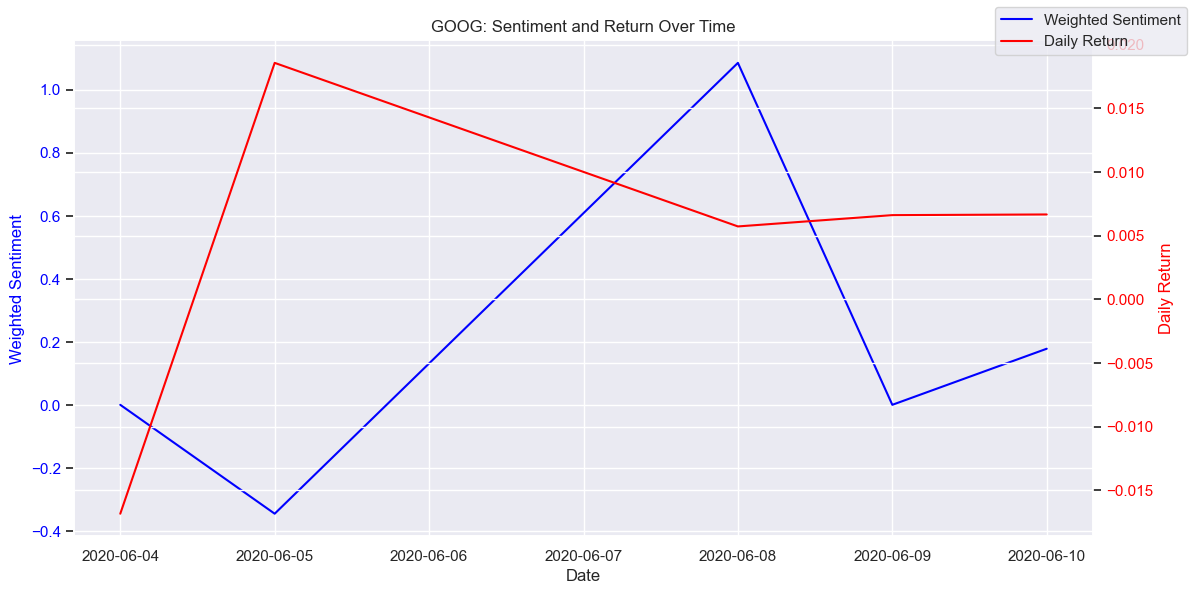

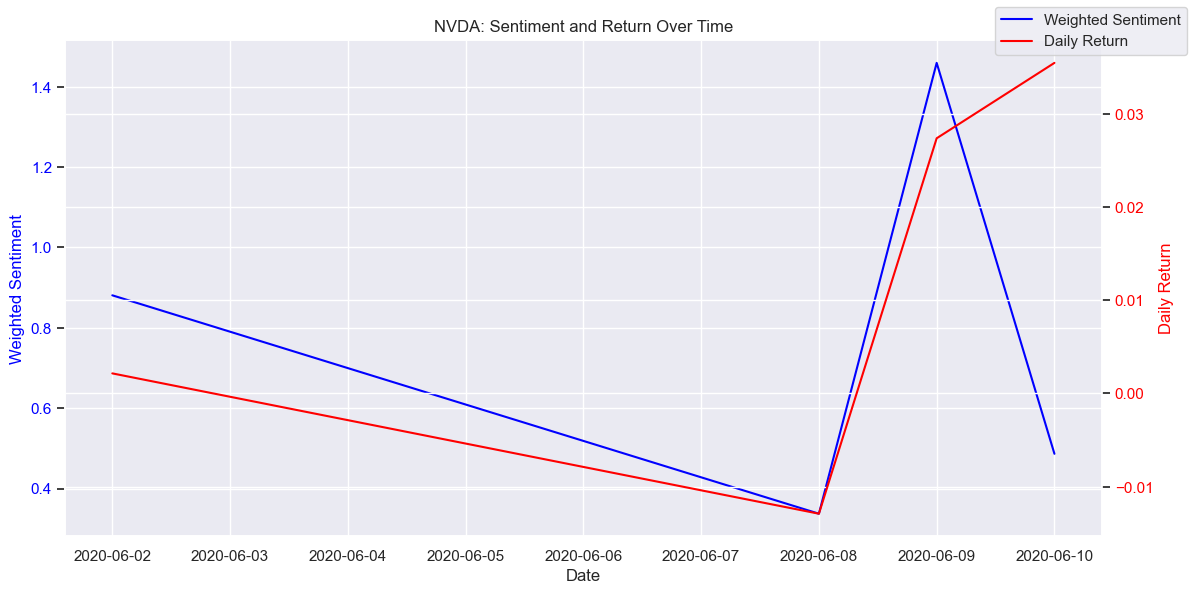

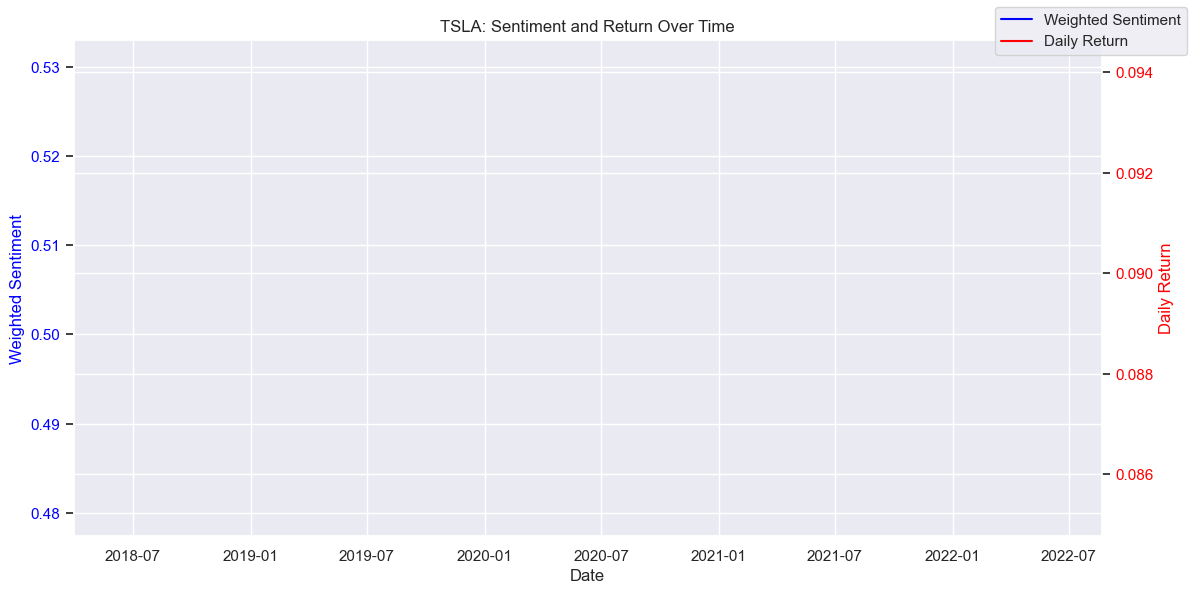

In [11]:
# Correlation Heatmaps
for ticker, result in corr_results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Pearson_Matrix'], annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'{ticker}: Pearson Correlation Heatmap (Weighted Sentiment)')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Spearman_Matrix'], annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'{ticker}: Spearman Correlation Heatmap (Weighted Sentiment)')
    plt.show()

# Scatter Plots: Sentiment vs. Return
for ticker in analysis_df['Ticker'].unique():
    ticker_data = analysis_df[analysis_df['Ticker'] == ticker]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Weighted_Sentiment', y='Return', data=ticker_data, alpha=0.5)
    plt.title(f'{ticker}: Weighted Sentiment vs. Daily Return')
    plt.xlabel('Weighted Sentiment')
    plt.ylabel('Daily Return')
    plt.show()

# Time Series: Sentiment and Return
for ticker in analysis_df['Ticker'].unique():
    ticker_data = analysis_df[analysis_df['Ticker'] == ticker].sort_values('Date')
    if len(ticker_data) > 100:
        ticker_data = ticker_data.tail(100)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(ticker_data['Date'], ticker_data['Weighted_Sentiment'], color='blue', label='Weighted Sentiment')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weighted Sentiment', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.plot(ticker_data['Date'], ticker_data['Return'], color='red', label='Daily Return')
    ax2.set_ylabel('Daily Return', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title(f'{ticker}: Sentiment and Return Over Time')
    fig.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 7. Topic-Based Correlations

Perform topic modeling and analyze correlations by topic.

Topics:
Topic 1: market, amazon, shares, morning, stats, start, minutes, currently, day, awaits
Topic 2: cannaphyll, google, company, consumer, mass, cannabis, platforms, marketing, amazon, sector
Topic 3: google, company, apple, amazon, covid, report, consumer, 19, higher, trading
Topic 4: tesla, 000, upside, industry, boost, target, bofa, stocks, amazon, high
Topic 5: market, despite, appears, recently, companies, sector, technology, trading, shares, stats


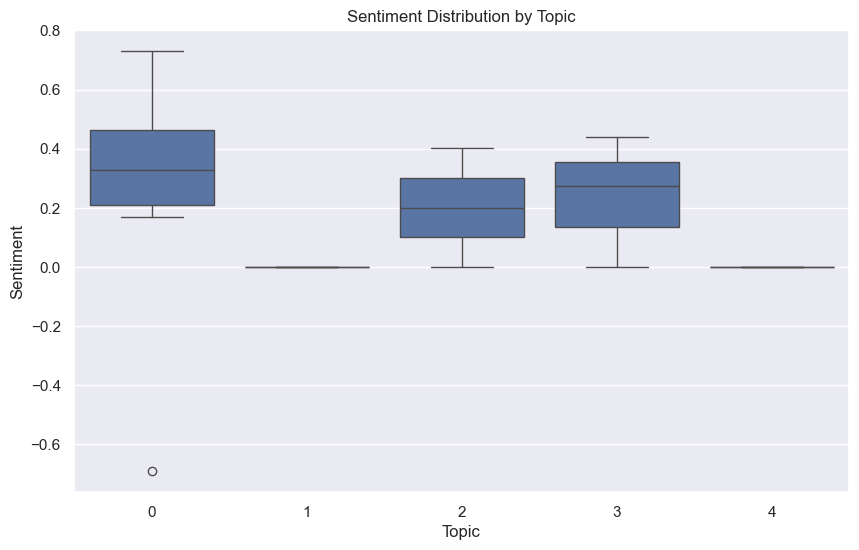

In [12]:
# Topic modeling
topics = simple_topic_modeling(ratings_df, n_topics=5, n_words=10)
print("Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

# Assign topics
def assign_topic(headline, topics):
    headline = str(headline).lower()
    for i, topic_words in enumerate(topics):
        if any(word in headline for word in topic_words):
            return i
    return -1

ratings_df['Topic'] = ratings_df['headline'].apply(lambda x: assign_topic(x, topics))

# Sentiment by topic
topic_sentiment = ratings_df[ratings_df['Topic'] != -1].groupby(['stock', 'Date', 'Topic'])['Sentiment'].mean().reset_index()
topic_sentiment.rename(columns={'stock': 'Ticker'}, inplace=True)

# Merge with stock data
topic_analysis_df = pd.merge(topic_sentiment, stock_df[['Ticker', 'Date', 'Return']], on=['Ticker', 'Date'], how='inner')

# Correlations by topic
for topic in topic_analysis_df['Topic'].unique():
    topic_data = topic_analysis_df[topic_analysis_df['Topic'] == topic]
    for ticker in topic_data['Ticker'].unique():
        ticker_data = topic_data[topic_data['Ticker'] == ticker]
        if len(ticker_data) < 10:
            continue
        corr = ticker_data[['Sentiment', 'Return']].corr(method='pearson').iloc[0, 1]
        print(f"Topic {topic+1}, {ticker}: Sentiment-Return Pearson Correlation = {corr:.4f}")

# Box Plot: Sentiment by Topic
plt.figure(figsize=(10, 6))
sns.boxplot(x='Topic', y='Sentiment', data=topic_analysis_df)
plt.title('Sentiment Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Sentiment')
plt.show()

## 8. Save Results

Save the analysis DataFrame and correlation results.

In [14]:
# Save analysis DataFrame
output_dir = os.path.join(project_root, 'data')
os.makedirs(output_dir, exist_ok=True)
analysis_df.to_csv(os.path.join(output_dir, 'correlation_data.csv'), index=False)
analysis_df_filtered.to_csv(os.path.join(output_dir, 'correlation_data_filtered.csv'), index=False)

# Save correlation results
corr_df = pd.DataFrame.from_dict({(ticker, k): v for ticker, res in corr_results.items() for k, v in res.items() if k not in ['Pearson_Matrix', 'Spearman_Matrix']}, orient='index')
corr_df.to_csv(os.path.join(output_dir, 'correlation_results.csv'))

print(f"Results saved to {output_dir}")

Results saved to c:\Users\hp\Desktop\Stock-market-movement-prediction-using-news-sentiment-nlp-\data
